In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('data/input/non_standardized_X_train.csv', index_col=0)
y_train = pd.read_csv('data/input/y_train.csv', index_col=0)

In [3]:
X_test = pd.read_csv('data/input/non_standardized_X_test.csv', index_col=0)

In [4]:
np.random.seed(42)

### 10-fold Cross-Validation

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [6]:
def kfold_mse(X, y, model, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train['sales']) # Avoid deprecation warning
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(y_pred, y_val['sales']))
    return mses

Gradient boosting have even more tunable parameters than random forest, therefore we shall concern only `learning_rate`, `max_depth` and `min_samples_leaf` in this project. `n_estimators`, `max_features`, `min_samples_split` are fixed to 1000, 'sqrt' and 0.01. Since boosting is robust to overfitting, we can use as many estimators as computationally feasible.

In [7]:
learning_rates = [0.01, 0.1, 0.5, 1]
max_depths = [None, 3, 5, 10]
min_samples_leaf = [1, 3, 5, 10, 20]

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
best_mses = []
best_avg_score = 1e9
best_lr = None
best_depth = None
best_msl = None
for lr in learning_rates:
    for depth in max_depths:
        for ml in min_samples_leaf:
            model = GradientBoostingRegressor(min_samples_leaf=ml, min_samples_split=0.01, n_estimators=1000, max_features='sqrt', random_state=42, learning_rate=lr, max_depth=depth)
            mses = kfold_mse(X_train, y_train, model)
            if np.mean(mses) < best_avg_score:
                best_avg_score = np.mean(mses)
                best_lr = lr
                best_depth = depth
                best_msl = ml
                best_mses = mses
            print(f'lr: {lr}, max_depth: {depth}, min_samples_leaf: {ml}, avg_mse: {np.mean(mses)}')

lr: 0.01, max_depth: None, min_samples_leaf: 1, avg_mse: 275.2030500192398
lr: 0.01, max_depth: None, min_samples_leaf: 3, avg_mse: 263.77721924904796
lr: 0.01, max_depth: None, min_samples_leaf: 5, avg_mse: 264.1719997036224
lr: 0.01, max_depth: None, min_samples_leaf: 10, avg_mse: 266.3335800410521
lr: 0.01, max_depth: None, min_samples_leaf: 20, avg_mse: 278.5520398753606
lr: 0.01, max_depth: 3, min_samples_leaf: 1, avg_mse: 345.195856634741
lr: 0.01, max_depth: 3, min_samples_leaf: 3, avg_mse: 339.4460841823976
lr: 0.01, max_depth: 3, min_samples_leaf: 5, avg_mse: 333.2997486386174
lr: 0.01, max_depth: 3, min_samples_leaf: 10, avg_mse: 333.2128135886446
lr: 0.01, max_depth: 3, min_samples_leaf: 20, avg_mse: 338.0234141097749
lr: 0.01, max_depth: 5, min_samples_leaf: 1, avg_mse: 288.7965775409493
lr: 0.01, max_depth: 5, min_samples_leaf: 3, avg_mse: 293.53118680463535
lr: 0.01, max_depth: 5, min_samples_leaf: 5, avg_mse: 290.85427861329083
lr: 0.01, max_depth: 5, min_samples_leaf: 1

### In-sample analysis

In [10]:
print(f'best lr: {best_lr}, best max_depth: {best_depth}, best min_samples_leaf: {best_msl}, best avg_mse: {np.mean(best_mses)}')

best lr: 0.1, best max_depth: 5, best min_samples_leaf: 5, best avg_mse: 252.2299183836407


In [11]:
cv_df = pd.DataFrame(best_mses, columns=['Cross-Validation MSE'])
cv_df

,Cross-Validation MSE
0,147.149551
1,168.336928
2,288.410559
3,214.791919
4,203.176895
5,112.132650
6,317.047179
7,160.066377
8,696.819174
9,214.367952


In [12]:
cv_df.to_csv('data/output/cv/gbr.csv')

### Model fitting

After finding best parameters (not applicable to LR but useful for other models), we fit the model on the entire training set and predict on the test set. Also, we collect residuals to prepare for inventory decision making.

In [13]:
gbr = GradientBoostingRegressor(min_samples_leaf=best_msl, min_samples_split=0.01, n_estimators=1000, max_features='sqrt', random_state=42, learning_rate=best_lr, max_depth=best_depth)
gbr.fit(X_train, y_train['sales']) # Avoid deprecation warning
residuals = y_train['sales'] - gbr.predict(X_train)

In [14]:
output_df = X_test.copy()

In [15]:
output_df['sales'] = gbr.predict(X_test)

### Inventory decision
As sales data come from a natural process, we shall not assume it is distributed in any particular model. Hence, we shall use an empirical distribution to make our inventory decision. 

In [16]:
residuals.describe()

count    2.211000e+03
mean     1.695212e-16
std      2.131703e+00
min     -1.077202e+01
25%     -1.070170e+00
50%     -6.455028e-02
75%      1.001918e+00
max      2.335370e+01
Name: sales, dtype: float64

For visualization of Empirical CDF, we use the `statsmodels` package:

In [17]:
from statsmodels.distributions.empirical_distribution import ECDF

In [18]:
ecdf = ECDF(residuals)

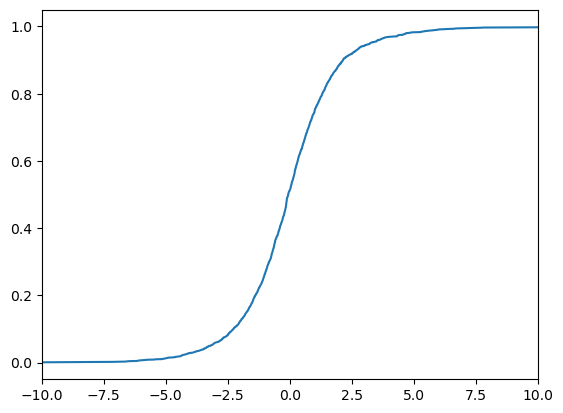

In [19]:
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-10, 10)
plt.show()

Sparsity is not a concern since we have a large sample size. Therefore, we can use interpolation to obtain ppf. To get the empirical ppf, we can use scipy's `interp1d` to get the inverse function:

In [20]:
from scipy.interpolate import interp1d

In [21]:
eppf = interp1d(ecdf.y, ecdf.x)

Calculate the critical fractile

In [22]:
price = 20
cost = 12
salvage = 8
over = cost - salvage
under = price - cost
critical_fractile = under / (over + under)
critical_fractile

0.6666666666666666

We offset our predictions for the test datasets by the $eppf(critical\_fractile)$ to get the optimal inventory level.

In [23]:
output_df['inventory'] = eppf(critical_fractile) + output_df['sales']

In [24]:
output_df[['sales', 'inventory']].head()

,sales,inventory
0,36.281540,36.888580
1,75.774899,76.381939
2,5.497576,6.104616
3,29.768925,30.375965
4,12.136878,12.743918


In [25]:
output_df.to_csv('data/output/predictions/gbr.csv')